<a href="https://colab.research.google.com/github/Chandana0127/Autism-Spectrum-Disorder-Project/blob/main/Autism_final_project_Naive_Bayes%2CCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# List files in a specific directory
directory_path = '/content/drive/MyDrive/Colab Notebooks/AUTISM TRY 2/autism'
files = os.listdir(directory_path)
print(files)


['valid', 'images to crop', 'tests_non_autistic', 'train', 'consolidated', 'test', 'classes.txt']


In [ ]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm

In [ ]:
def make_dataframes():
    print('Enter the full path to the directory containing the train, test and valid sub directories')
    sdir=input(' ')
    dataset_names= ['train', 'test' ,'valid']
    train_path=os.path.join(sdir, 'train')
    test_path=os.path.join(sdir, 'test')
    valid_path=os.path.join(sdir, 'valid')
    path_list=[train_path, test_path, valid_path]
    zip_list=zip(dataset_names, path_list)

    # generate train_df, test_df, valid_df
    for dataset, setpath in zip_list:
        filepaths=[]
        labels=[]
        classes=sorted(os.listdir(setpath))
        for klass in classes:
            classpath=os.path.join(setpath, klass)
            flist=sorted(os.listdir(classpath))
            desc=f'{dataset:6s}-{klass:13s}'
            for f in tqdm(flist, ncols=130, desc=desc):
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
        Fseries=pd.Series(filepaths, name='filepaths')
        Lseries=pd.Series(labels, name='labels')
        df=pd.concat([Fseries, Lseries], axis=1)
        if dataset =='train':
            train_df=df
        elif dataset == 'test':
            test_df=df
        else:
            valid_df=df
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)
    counts=list(train_df['labels'].value_counts())
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)
    return train_df, test_df, valid_df, classes, class_count, sdir

In [ ]:
train_df, test_df, valid_df, classes, class_count, sdir=make_dataframes()

Enter the full path to the directory containing the train, test and valid sub directories
 /content/drive/MyDrive/Colab Notebooks/AUTISM TRY 2/autism


valid -non_autistic : 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 270077.53it/s]


number of classes in processed dataset=  2
the maximum files in any class in train_df is  1263   the minimum files in any class in train_df is  1263
train_df length:  2526   test_df length:  200   valid_df length:  200
average image height=  361   average image width=  312  aspect ratio h/w=  1.1570512820512822


In [ ]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator()
    #trgen=ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20 )
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes


batch_size=20
img_size=(200,200)
train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes=make_gens(batch_size, train_df, test_df, valid_df, img_size)


Found 2526 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
test batch size:  50   test steps:  4  number of classes :  2


In [ ]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=20,
        zoom_range=0.2,
        shear_range=0.2
    )

    t_and_v_gen = ImageDataGenerator(rescale=1./255)

    print(f"{'Generating train generator':70s}", '\r', end='')
    train_gen = trgen.flow_from_dataframe(
        train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='binary',  # Ensure binary classification
        color_mode='rgb',
        shuffle=True,
        batch_size=batch_size
    )

    print(f"{'Generating valid generator':70s}", '\r', end='')
    valid_gen = t_and_v_gen.flow_from_dataframe(
        valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='binary',  # Ensure binary classification
        color_mode='rgb',
        shuffle=False,
        batch_size=batch_size
    )

    length = len(test_df)
    test_batch_size = sorted([int(length / n) for n in range(1, length + 1) if length % n == 0 and length / n <= 80], reverse=True)[0]
    test_steps = int(length / test_batch_size)

    print(f"{'Generating test generator':70s}", '\r', end='')
    test_gen = t_and_v_gen.flow_from_dataframe(
        test_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='binary',  # Ensure binary classification
        color_mode='rgb',
        shuffle=False,
        batch_size=test_batch_size
    )

    class_count = 2  # Since it's binary classification
    print(f"Test batch size: {test_batch_size}, Test steps: {test_steps}, Number of classes: {class_count}")

    return train_gen, test_gen, valid_gen, test_batch_size, test_steps


In [ ]:
content=str(classes)
for char in ['\'', '[', ']', ' ']:
    content=content.replace(char, '')
wpath=os.path.join(sdir,'classes.txt')
with open(wpath , 'w') as f:
    f.write(content)
# the file is stored in the sdir as classes.txt

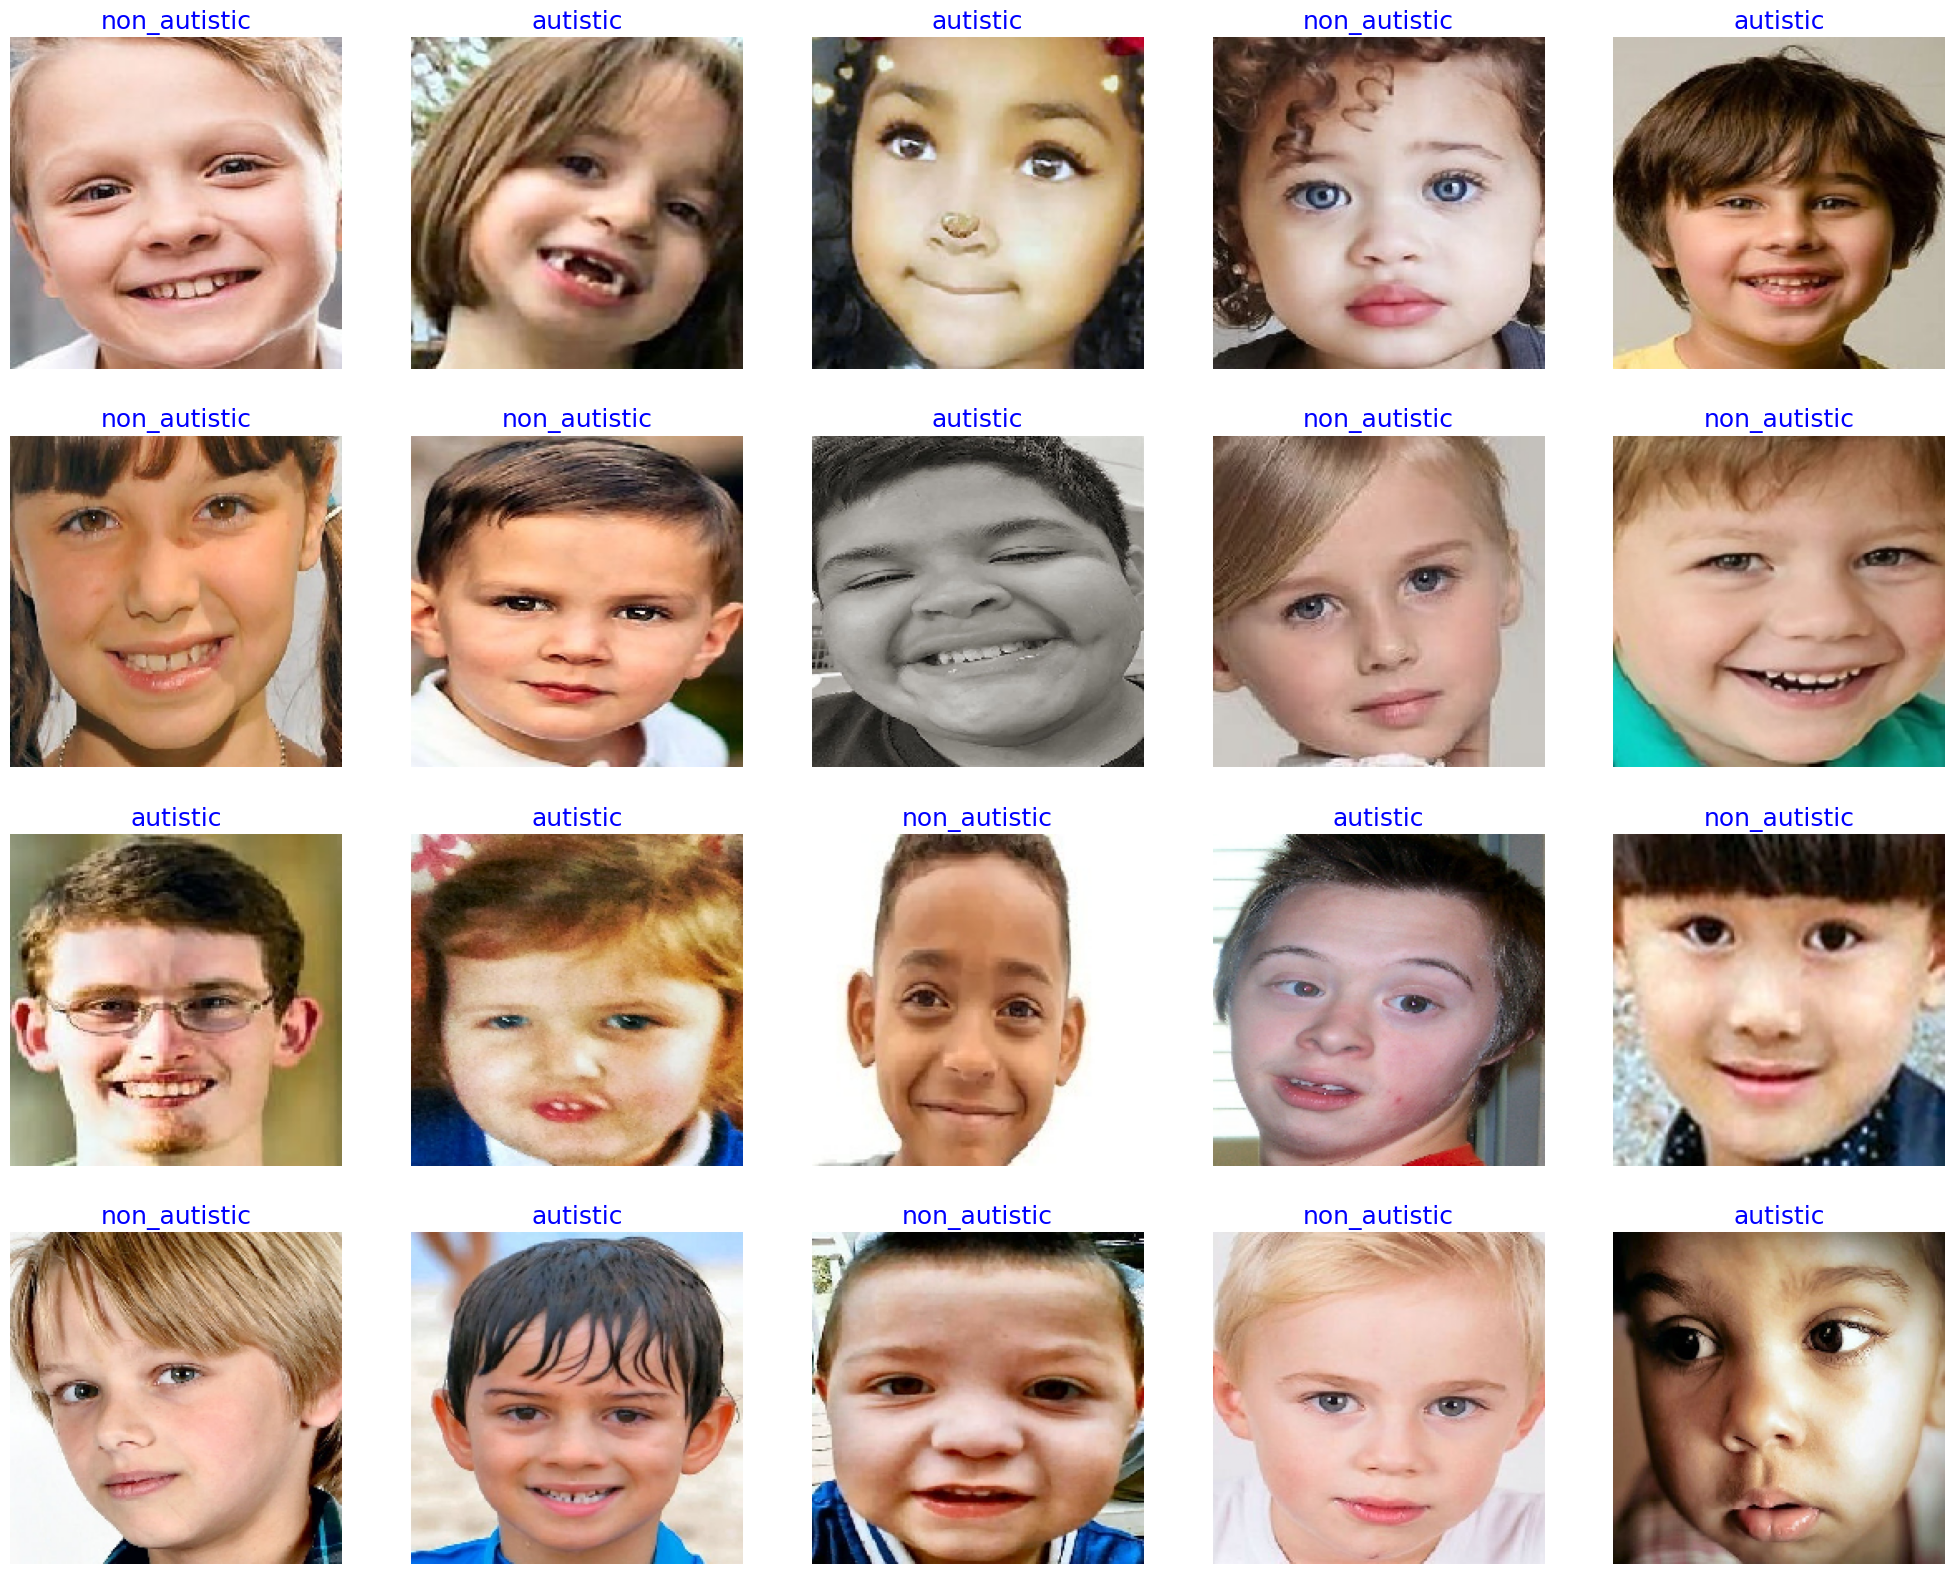

In [ ]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen )

In [ ]:
import os

def load_data_from_folder(folder_path):
    data = []
    labels = {'autistic': 1, 'non_autistic': 0}  # Assign labels for each subfolder

    # Check if directory is empty or does not exist
    if not os.path.isdir(folder_path) or not os.listdir(folder_path):
        print(f"Warning: {folder_path} is empty or does not exist.")
        return data

    # Iterate through subfolders
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path) and subfolder in labels:
            # Iterate through files in each subfolder
            for filename in os.listdir(subfolder_path):
                if filename.endswith('.jpg'):  # Adjust extensions as needed
                    data.append((os.path.join(subfolder_path, filename), labels[subfolder]))

    return data


In [ ]:
# Define folder paths
train_path = '/content/drive/MyDrive/Colab Notebooks/AUTISM TRY 2/autism/train'
test_path = '/content/drive/MyDrive/Colab Notebooks/AUTISM TRY 2/autism/test'
valid_path = '/content/drive/MyDrive/Colab Notebooks/AUTISM TRY 2/autism/valid'

# Load data
train_data = load_data_from_folder(train_path)
test_data = load_data_from_folder(test_path)
valid_data = load_data_from_folder(valid_path)

# Convert to DataFrame
import pandas as pd

df_train = pd.DataFrame(train_data, columns=['filepaths', 'labels'])
df_test = pd.DataFrame(test_data, columns=['filepaths', 'labels'])
df_valid = pd.DataFrame(valid_data, columns=['filepaths', 'labels'])

# Extract features from images
def extract_features(image_paths, img_size):
    features = []
    for path in image_paths:
        img = load_img(path, target_size=img_size, color_mode='rgb')
        img_array = img_to_array(img)
        img_array = img_array.flatten()  # Flatten the image to a 1D array
        features.append(img_array)
    return np.array(features)

img_size = (200, 200)  # Define image size
train_features = extract_features(df_train['filepaths'], img_size)
test_features = extract_features(df_test['filepaths'], img_size)
valid_features = extract_features(df_valid['filepaths'], img_size)

# Prepare labels
train_labels = df_train['labels'].values
test_labels = df_test['labels'].values
valid_labels = df_valid['labels'].values

# Train Naive Bayes model
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

model = GaussianNB()
model.fit(train_features, train_labels)

# Make predictions
valid_preds = model.predict(valid_features)
test_preds = model.predict(test_features)

# Evaluate the model
print('Validation Results:')
print('Accuracy:', accuracy_score(valid_labels, valid_preds))
print('Classification Report:')
print(classification_report(valid_labels, valid_preds))

print('Test Results:')
print('Accuracy:', accuracy_score(test_labels, test_preds))
print('Classification Report:')
print(classification_report(test_labels, test_preds))


Validation Results:
Accuracy: 0.64
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.71      0.66       100
           1       0.66      0.57      0.61       100

    accuracy                           0.64       200
   macro avg       0.64      0.64      0.64       200
weighted avg       0.64      0.64      0.64       200

Test Results:
Accuracy: 0.7
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.77      0.72       100
           1       0.73      0.63      0.68       100

    accuracy                           0.70       200
   macro avg       0.70      0.70      0.70       200
weighted avg       0.70      0.70      0.70       200



In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report

# Define parameters
img_size = (200, 200)  # Image size for resizing
batch_size = 20

def load_data_from_folder(folder_path):
    data = []
    labels = {'autistic': 1, 'non_autistic': 0}  # Assign labels for each subfolder

    # Check if directory is empty or does not exist
    if not os.path.isdir(folder_path) or not os.listdir(folder_path):
        print(f"Warning: {folder_path} is empty or does not exist.")
        return data

    # Iterate through subfolders
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path) and subfolder in labels:
            # Iterate through files in each subfolder
            for filename in os.listdir(subfolder_path):
                if filename.endswith('.jpg'):  # Adjust extensions as needed
                    data.append((os.path.join(subfolder_path, filename), labels[subfolder]))

    return data

# Load data
train_path = '/content/drive/MyDrive/Colab Notebooks/AUTISM TRY 2/autism/train'
test_path = '/content/drive/MyDrive/Colab Notebooks/AUTISM TRY 2/autism/test'
valid_path = '/content/drive/MyDrive/Colab Notebooks/AUTISM TRY 2/autism/valid'

train_data = load_data_from_folder(train_path)
test_data = load_data_from_folder(test_path)
valid_data = load_data_from_folder(valid_path)

# Convert to DataFrame
df_train = pd.DataFrame(train_data, columns=['filepaths', 'labels'])
df_test = pd.DataFrame(test_data, columns=['filepaths', 'labels'])
df_valid = pd.DataFrame(valid_data, columns=['filepaths', 'labels'])

df_train['labels'] = df_train['labels'].astype(str)
df_test['labels'] = df_test['labels'].astype(str)
df_valid['labels'] = df_valid['labels'].astype(str)


# Define ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create Generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

valid_generator = test_datagen.flow_from_dataframe(
    dataframe=df_valid,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Define CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.2f}")

# Predict and evaluate on test set
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = (predictions > 0.5).astype("int32")

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print classification report
print('Classification Report:')
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


Found 2526 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


127/127 ━━━━━━━━━━━━━━━━━━━━ 326s 3s/step - accuracy: 0.5219 - loss: 1.4189 - val_accuracy: 0.5800 - val_loss: 0.6693
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.5902 - loss: 0.6855 - val_accuracy: 0.6050 - val_loss: 0.6572
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.6317 - loss: 0.6519 - val_accuracy: 0.5600 - val_loss: 0.6726
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.6274 - loss: 0.6525 - val_accuracy: 0.6150 - val_loss: 0.6825
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.6484 - loss: 0.6224 - val_accuracy: 0.6550 - val_loss: 0.6043
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.6819 - loss: 0.6048 - val_accuracy: 0.6850 - val_loss: 0.6018
Epoch 7/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.6827 - loss: 0.6026 - val_accuracy: 0.6800 - val_loss: 0.6190
Epoch 8/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.7008 - loss: 0.5777 - val_accuracy: 0.710

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
